# 🦌 RuDOLPH 350M

<b><font color="white" size="+2">Official colab of [RuDOLPH: One Hyper-Modal Transformer can be creative as DALL-E and smart as CLIP](https://github.com/sberbank-ai/ru-dolph)</font></b>


<font color="white" size="-0.75."><b>RuDOLPH</b> is a fast and light text-image-text transformer (350M GPT-3) for generating text like <b>GPT</b>, generating image (e.g.: image by text, image by image prompt) like <b>DALL-E</b>, generating image captions, image classification in Zero-Shot mode and image ranking like <b>CLIP</b>. 

<b>RuDOLPH 350M</b> is designed for quick and easy fine-tuning setup for solution of various tasks: from generating images by text description and image classification, to visual question answering and more. This colab demonstates the power of Hyper-Modal Transfomers.</font>

Hyper-modality means generalized multi-modal, e.g., model that consists of two multi-modal parts: text-2-image and image-2-text becomes text and image hyper-modality model

<font color="white" size="-0.75."><b>RuDOLPH for fast zero-shot text to image generation.</b> On the first phase we generate 288 in 5 min images by text! It takes Diffusion decoder is based on [Jack000](https://github.com/Jack000/) solution and ESRGAN-Real for high quality image rendering.</font>

# install all

In [ ]:
!pip install rudolph==0.0.1rc4 > /dev/null
!pip install bitsandbytes-cuda111 > /dev/null
!pip install wandb > /dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


#Download data

In [ ]:
!gdown https://drive.google.com/uc?id=17bPt7G3N_vGKCCxppIOPbPlhv1qUnv0o
!unzip -qn food.zip > /dev/null

Downloading...
From: https://drive.google.com/uc?id=17bPt7G3N_vGKCCxppIOPbPlhv1qUnv0o
To: /content/food.zip
100% 34.8M/34.8M [00:00<00:00, 163MB/s]
food/Булочки с начинкой «Молочная нежность».jpg:  mismatching "local" filename (food/╨С╤Г╨╗╨╛╤З╨║╨╕ ╤Б ╨╜╨░╤З╨╕╨╜╨║╨╛╨╣ ┬л╨Ь╨╛╨╗╨╛╤З╨╜╨░╤П ╨╜╨╡╨╢╨╜╨╛╤Б╤В╤М┬╗.jpg),
         continuing with "central" filename version
food/Запеченный картофель «Чесночно-сырный».jpg:  mismatching "local" filename (food/╨Ч╨░╨┐╨╡╤З╨╡╨╜╨╜╤Л╨╣ ╨║╨░╤А╤В╨╛╤Д╨╡╨╗╤М ┬л╨з╨╡╤Б╨╜╨╛╤З╨╜╨╛-╤Б╤Л╤А╨╜╤Л╨╣┬╗.jpg),
         continuing with "central" filename version
food/Лепешки «В путь дорожку!».jpg:  mismatching "local" filename (food/╨Ы╨╡╨┐╨╡╤И╨║╨╕ ┬л╨Т ╨┐╤Г╤В╤М ╨┤╨╛╤А╨╛╨╢╨║╤Г!┬╗.jpg),
         continuing with "central" filename version
food/Салат «Анастасия».jpg:  mismatching "local" filename (food/╨б╨░╨╗╨░╤В ┬л╨Р╨╜╨░╤Б╤В╨░╤Б╨╕╤П┬╗.jpg),
         continuing with "central" filename version
food/Салат «Коко Шанель».jpg:  mismatching "local" filename (food/╨б╨░╨╗╨░╤В ┬л╨Ъ╨╛╨║╨

# Train this deer🦌🦌🦌

In [ ]:
import os
import sys
import random
from collections import Counter

import PIL
import torch
import numpy as np
import pandas as pd
import bitsandbytes as bnb
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from tqdm import tqdm
from wordcloud import WordCloud
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
from rudalle import get_tokenizer, get_vae
from rudalle.utils import seed_everything

from rudolph.model.utils import get_attention_mask
from rudolph.model import get_rudolph_model, ruDolphModel, FP16Module
from rudolph.pipelines import generate_codebooks, self_reranking_by_image, self_reranking_by_text, show, generate_captions, generate_texts, zs_clf
from rudolph import utils

In [ ]:
device = 'cuda'

model = get_rudolph_model('350M',  fp16=True, device='cuda')
tokenizer = get_tokenizer()
vae = get_vae(dwt=False).to(device)

Downloading:   0%|          | 0.00/707M [00:00<?, ?B/s]

Russian Diffusion On Language Picture Hyper-modality (RuDOLPH 🦌🎄☃️) 350M is a fast and light text-image-text transformer (350M GPT-3) designed for a quick and easy fine-tuning setup for the solution of various tasks: from generating images by text description and image classification to visual question answering and more. 
This model demonstrates the power of Hyper-modality Transformers.


Downloading:   0%|          | 0.00/224k [00:00<?, ?B/s]

tokenizer --> ready
Working with z of shape (1, 256, 32, 32) = 262144 dimensions.


Downloading:   0%|          | 0.00/346M [00:00<?, ?B/s]

vae --> ready


In [ ]:
class Args():
    def __init__(self, model):
        self.device = model.get_param('device')
        self.l_text_seq_length = model.get_param('l_text_seq_length')
        self.r_text_seq_length = model.get_param('r_text_seq_length')
        self.image_tokens_per_dim = model.get_param('image_tokens_per_dim')
        self.image_seq_length = model.get_param('image_seq_length')
        self.epochs = 5
        self.save_path='checkpoints/'
        self.model_name = 'awesomemodel_'
        self.save_every = 500
        self.bs = 10
        self.clip = 1.0
        self.lr = 2e-5
        self.wandb = False
        self.lt_loss_weight = 0.01
        self.img_loss_weight = 1
        self.rt_loss_weight = 7
        self.image_size = self.image_tokens_per_dim * 8

args = Args(model)
if not os.path.exists(args.save_path):
    os.makedirs(args.save_path)

In [ ]:
class FoodDataset(Dataset):
    def __init__(self, file_path, csv_path, tokenizer, shuffle=True):
        self.tokenizer = tokenizer
        self.samples = []
        self.image_transform = T.Compose([
            T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
            T.RandomResizedCrop(args.image_size, scale=(1., 1.), ratio=(1., 1.)),
            T.ToTensor()
        ])

        df = pd.read_csv(csv_path)
        df.columns = ['index', 'belok', 'fats', 'uglevod', 'kkal', 'name', 'path']

        for belok, fats, uglevod, kkal, caption, f_path in zip(
            df['belok'],df['fats'], df['uglevod'], df['kkal'], df['name'], df['path']
        ):
            caption = f'блюдо: {caption}; белков: {belok}; жиров: {fats}; углеводов: {uglevod}; ккал: {kkal};'
            if len(caption)>10 and len(caption)<100 and os.path.isfile(f'{file_path}/{f_path}'):
                self.samples.append([file_path, f_path, caption.lower()])
        if shuffle:
            np.random.shuffle(self.samples)
            print('Shuffled')

    def __len__(self):
        return len(self.samples)

    def load_image(self, file_path, img_name):
        return PIL.Image.open(f'{file_path}/{img_name}')

    def __getitem__(self, item):
        item = item % len(self.samples)
        file_path, img_name, text = self.samples[item]

        try:
            image = self.load_image(file_path, img_name)
            image = self.image_transform(image)
        except Exception as err:  
            print(err)
            random_item = random.randint(0, len(self.samples) - 1)
            return self.__getitem__(random_item)
        text = text.lower().strip()
        encoded = self.tokenizer.encode_text(text, text_seq_length=args.r_text_seq_length)       
        return encoded, image

#Lets look what is inside food Dataset 🤔

In [ ]:
dataset = FoodDataset(file_path='/content/food' ,csv_path ='/content/food/food.csv',tokenizer=tokenizer)
train_dataloader = DataLoader(dataset, batch_size=args.bs, shuffle=True, drop_last=True)

Shuffled


блюдо: салат с курицей ; белков: 8.8; жиров: 8.2; углеводов: 5.1; ккал: 131.0;


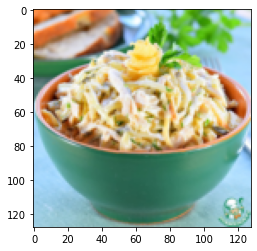

In [ ]:
idx = random.randint(0, len(dataset)-1)
encoded, image = dataset[idx]

print(tokenizer.decode_text(encoded))

plt.imshow(image.permute(1,2,0).cpu().numpy());

блюдо: салат ; белков: 15.8; жиров: 5.5; углеводов: 3.0; ккал: 126.7;


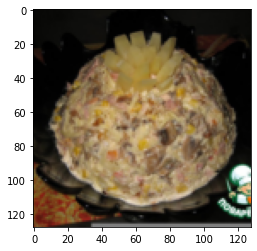

In [ ]:
idx = random.randint(0, len(dataset)-1)
encoded, image = dataset[idx]

print(tokenizer.decode_text(encoded))

plt.imshow(image.permute(1,2,0).cpu().numpy());

In [ ]:
df = pd.read_csv('/content/food/food.csv')
wc, c = WordCloud(), Counter()

for text in df['name']:
  try:
    c.update(wc.process_text(text))    
  except:
    continue

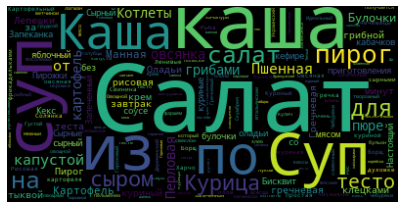

In [ ]:
wc.fit_words(c)
plt.figure(figsize=(7,7));
plt.imshow(wc, interpolation='bilinear');
plt.axis("off");

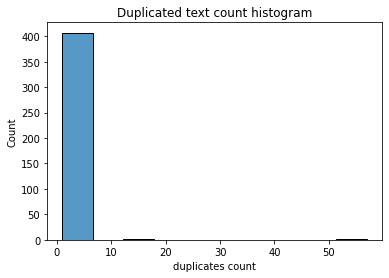

In [ ]:
import seaborn as sns
text_value_counts = pd.DataFrame(df['name'].value_counts())
ax = sns.histplot(data=text_value_counts, x="name");
ax.set_title('Duplicated text count histogram');
ax.set_xlabel('duplicates count');

#Train this deer 🦌🎄☃️

In [ ]:
try:
    if args.wandb:
        import wandb
        wandb.init(project = args.model_name)
except:
    args.wandb = False
    print('If you want to use wandb logs pls login via wandb -login')

In [ ]:
def freeze(
    model,
    freeze_emb=False,
    freeze_ln=False,
    freeze_attn=True,
    freeze_ff=True,
    freeze_other=False,
):
    for name, p in model.module.named_parameters():
        name = name.lower()
        if 'ln' in name or 'norm' in name:
            p.requires_grad = not freeze_ln
        elif 'embeddings' in name:
            p.requires_grad = not freeze_emb
        elif 'mlp' in name:
            p.requires_grad = not freeze_ff
        elif 'attn' in name:
            p.requires_grad = not freeze_attn
        else:
            p.requires_grad = not freeze_other
    return model

In [ ]:
model.train()
optimizer = bnb.optim.Adam8bit(model.parameters(), lr=args.lr)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=args.lr, final_div_factor=500, 
    steps_per_epoch=len(train_dataloader), epochs=args.epochs 
)

# Lets train for captioning task, test trained model [here](https://huggingface.co/spaces/AlexWortega/food_calories)

In [ ]:
def train(model,args: Args, train_dataloader: FoodDataset):
  """
  args - arguments for training

  train_dataloader - RuDalleDataset class with text - image pair in batch
  """

  loss_logs = []
  try:
    progress = tqdm(total=len(train_dataloader)*args.epochs, desc='finetuning goes brrr🦌🎄☃️')
    save_counter = 0

    for epoch in range(args.epochs):
      
      for text, images in train_dataloader:
        
        save_counter+=1
        model.zero_grad()

        total_seq_length = args.l_text_seq_length + args.image_seq_length + args.r_text_seq_length
        masks = torch.ones(args.bs, args.r_text_seq_length, dtype=torch.int32)

        attention_mask = get_attention_mask(masks, args.bs, args.l_text_seq_length, args.image_tokens_per_dim,
                                                    args.r_text_seq_length, device)

        image_input_ids = vae.get_codebook_indices(images.to(device))
        r_text = text.to(device)
        l_text = torch.zeros((args.bs, args.l_text_seq_length), device=device, dtype=torch.long)
        input_ids = torch.cat((l_text, image_input_ids, r_text), dim=1)


        loss, loss_values = model.forward(input_ids, attention_mask, lt_loss_weight=args.lt_loss_weight,
        img_loss_weight=args.img_loss_weight,rt_loss_weight=args.rt_loss_weight,  return_loss=True)

        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(),args.clip)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        if save_counter % args.save_every == 0:
            print(f'Saveing checkpoint here {args.model_name}_dalle_{save_counter}.pt')
            plt.plot(loss_logs)
            plt.show()
            torch.save(
                model.state_dict(),
                os.path.join(args.save_path,f"{args.model_name}_dalle_{save_counter}.pt")
            )

        if args.wandb:
            wandb.log({"loss":  loss.item()})
        loss_logs+=[loss.item()]
        progress.update()
        progress.set_postfix({"loss": loss.item()})
    
    print(f'Complitly tuned and saved here  {args.model_name}__dalle_last.pt')
    plt.plot(loss_logs)
    plt.show()
    torch.save(
        model.state_dict(),
        os.path.join(args.save_path,f"{args.model_name}dalle_last.pt")
    )
  
  except KeyboardInterrupt:
    
    
    print(f'What for did you stopped? Please change model_path to /{args.save_path}/{args.model_name}_rudolf_Failed_train')
    plt.plot(loss_logs)
    plt.show()
    
    torch.save(
                model.state_dict(),
                os.path.join(args.save_path,f"{args.model_name}_rudolf_Failed_train.pt")
                )
  except Exception as err:
    print(f'Failed with {err}')


finetuning goes brrr🦌🎄☃️:   0%|          | 0/235 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/rudolph/model/model.py:94: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dtype=torch.long, device=device) // self.image_tokens_per_dim
finetuning goes brrr🦌🎄☃️: 100%|██████████| 235/235 [05:27<00:00,  1.39s/it, loss=1.63]

Complitly tuned and saved here  awesomemodel___dalle_last.pt


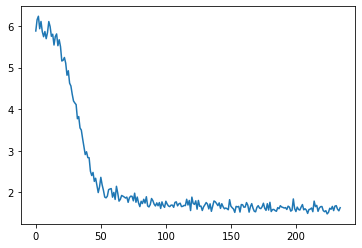

finetuning goes brrr🦌🎄☃️: 100%|██████████| 235/235 [05:28<00:00,  1.40s/it, loss=1.63]


In [ ]:
model = freeze(
    model=model,
    freeze_emb=False,
    freeze_ln=False,
    freeze_attn=True,
    freeze_ff=True,
    freeze_other=False,
)  #freeze params to 

train(model, args, train_dataloader)

# 🖼2✍ Lets test trained model

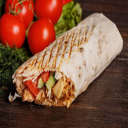

  0%|          | 0/61 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/rudolph/model/model.py:94: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dtype=torch.long, device=device) // self.image_tokens_per_dim


блюдо: куриный рулет с сыром в духовке; белков: 3.2; жиров: 3.4; углеводов: 18.6; ккал: 125.8;
блюдо: говядина в духовке; белков: 4.3; жиров: 2.1; углеводов: 46.3; ккал: 93.2;
блюдо: блинный рулет с мясом; белков: 8.7; жиров: 12.3; углеводов: 29.2; ккал: 33.1;
блюдо: рулет ; белков: 3.7; жиров: 2.7; углеводов: 4.3; ккал: 132.4;


In [ ]:
template = 'блюдо:'

import requests
from PIL import Image
import torch


img_by_url = 'https://kulinarenok.ru/img/steps/31445/1-7.jpg' #@param {type:"string"}
# img_by_url = 'https://img.delo-vcusa.ru/2020/11/Borshh-s-yablokami.jpg' 

img_by_url = Image.open(requests.get(img_by_url, stream=True).raw).resize((128, 128))
#@markdown number of images
captions_num = 4 #@param{type:'slider'}
display(img_by_url)

texts = generate_captions(img_by_url, tokenizer, model, vae, template=template, 
                          top_k=16, captions_num=captions_num, bs=16, top_p=0.6, seed=43, 
                          temperature=0.8, limit_eos=False)
ppl_text, ppl_image = self_reranking_by_image(texts, img_by_url, tokenizer, model, vae, bs=16, seed=42)
for idx in ppl_image.argsort()[:8]:
    print(texts[idx])